# Laboratório 01 fast.ai DL1 2019 Brasília


### Introdução

Bem vindos ao primeiro laboratório da turma fast.ai DL1 2019. O objetivo do laboratório é consolidar os conhecimentos obtidos nas aulas 01 e 02, bem como promover debate, discussões relacionadas ao tema, bem como fazer com que a maioria finalmente coloque a "mão na massa" como gosta nosso guru, Jeremy.

Realizaremos nesse laboratório o treinamento de uma rede neural para classificação de expressões faciais baseadas em fotos de pessoas. Utilizaremos a base de dados de um desafio do Kaggle de 2013, conforme detalhes mais adiante. O modelo treinado terá alcançado uma acurácia similiar, ou até superior, aos melhores modelos vencedores da competição em 2013. Além disso, vamos desenvolver um aplicativo web simples para colocar em produção nosso modelo treinado de a nos permitir testar novas imagens com expressões a avaliar a acurácia da rede neural na prática.

Esse notebook é uma combinação de dois posts do colega [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/), que cedeu seu código para que possamos consolidar nossos conhecimentos:

- [Face Expression Recognition with fastai v1](https://medium.com/@pierre_guillou/face-expression-recognition-with-fastai-v1-dc4cf6b141a3).
- [Deep Learning Web App by fastai v1](https://medium.com/@pierre_guillou/deep-learning-web-app-by-fastai-v1-3ab4c20b7cac)


### Reconhecimento de Expressões Faciais (Face Expression Recognition Kaggle Challenge - FER 2013) com fastai v1

by: [Pierre Guillou](https://www.linkedin.com/in/pierreguillou/) (novembro 2018) e 
    [Leon Silva](https://www.linkedin.com/in/leonsolon/) (tradução/atualização março 2019)

- Inspirado por [Recognizing Facial Expressions Using Deep Learning](http://cs231n.stanford.edu/reports/2017/pdfs/224.pdf) (2017) of Alexandru Savoiu and James Wong (Stanford University)
- Base de dados : [FER 2013 Kaggle Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/)
- Deep Learning utilizando [fastai v1](https://www.fast.ai/2018/10/02/fastai-ai/)

# Inicialização

Vamos começar como todo e qualquer notebook que utiliza fast.ai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Configuração da API Kaggle

Faremos o download do banco de imagens diretamente do Kaggle. Para tal, é necessário seguir os passos abaixo. Este notebook está focalizado na google cloud platform (gcp), tendo em vista que a maioria da turma realizou essa instalação. Se você está lendo isso é porque já está rodando o jupyter de alguma forma, seja na máquina local, seja no gcp, portanto, pularemos os passos de inicialização da instância e do jupyter.

1. Caso ainda não possua, cria sua conta no [Kaggle](https://www.kaggle.com) no seu computador local
2. No canto superior direito, clique na sua foto (ou avatar) e selecione 'My account'
3. Selecione a opção 'Create API Token'. Ao selecionar a opção será baixado o `kaggle.json`, um arquivo contendo as credenciais da API (nome de usuário e senha)
4. No terminal SSH da instância instale a [API do Kaggle](https://github.com/Kaggle/kaggle-api) para permitir que possamos realizar o download direatamente na instância. Para tal rode o comando `sudo pip install kaggle` no terminal
5. Se lembra do arquivo `kaggle.json`? Faça o upload do arquivo na pasta que desejar. É importante saber onde ele estará na instância, pois o próximo passo é movê-lo de lugar
6. Mova o arquivo `kaggle.json` para `~/.kaggle/kaggle.json` (ex: `mv /home/jupyter/tutorials/fastai/course-v3/kaggle.json ~/.kaggle`. É possível que, mesmo depois da instalação da API do Kaggle, você tenha que criar a pasta antes de copiar o arquivo: `mkdir ~/.kaggle`
7. Por questões de segurança, garanta que outros usuários do seu computador não tenham acesso de leitura às suas credenciais. Esse comando é necessário, do contrário a API do Kaggle se recusa a fazer o download das bases de dados. Em SOs baseados em Unix você pode rodar o comando:  `chmod 600 ~/.kaggle/kaggle.json`
8. Acesse a seção `rules` da [página da competição](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/rules) e clique em `I Understand and Accept`. Este passo é necessário para autorização do download da base de dados

# Dados

## Download do Kaggle

Agora que temos a conta, chave de API e pacote instalado, basta realizarmos o download em si. Os próximos passos são comandos linux para bash que serão executados na instância.

In [3]:
# Comando para apresentar qual o local atual no sistema de arquivos
%pwd

'/home/jupyter/tutorials/fastai/course-v3/nbs/dl1/laboratorios/01'

In [4]:
# Comando para alterar pasta para '~/.fastai/data'. 
%cd ~/.fastai/data/

# Finnalmente, download do arquivo FER 2013 a partir da conta do Kaggle (fer2013.tar.gz)
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

/home/leonsolon/.fastai/data


In [9]:
# Descompactar o arquivo dentro da pasta FER (criada no primeiro comando)
!mkdir FER
!mv fer2013.tar.gz FER
!mv example_submission.csv FER
!tar -xvf FER/fer2013.tar.gz -C FER

fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


## Listando arquivos

In [5]:
%cd ~/.fastai/data/
PATH = Path('./FER/fer2013')
PATH.ls()

/home/leonsolon/.fastai/data


[PosixPath('FER/fer2013/models'),
 PosixPath('FER/fer2013/valid'),
 PosixPath('FER/fer2013/test'),
 PosixPath('FER/fer2013/fer2013.csv'),
 PosixPath('FER/fer2013/README'),
 PosixPath('FER/fer2013/fer2013.bib'),
 PosixPath('FER/fer2013/train')]

In [6]:
df = pd.read_csv(PATH/'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
# 7 types (emotions) of images from the Data Description of the Kaggle challenge
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
for l in range(len(labels)):
    print(f'{l} = {labels[l]}')

0 = Angry
1 = Disgust
2 = Fear
3 = Happy
4 = Sad
5 = Surprise
6 = Neutral


In [8]:
# 3 usages of the images
usages = df['Usage'].unique();usages

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [9]:
df_train = df[df['Usage'] == 'Training']
df_valid = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

n_train = len(df_train)
n_valid = len(df_valid)
n_test = len(df_test)
n = len(df)

print(f'{n_train} (Training) + {n_valid} (PublicTest) + {n_test} (PrivateTest) = {n} images')

28709 (Training) + 3589 (PublicTest) + 3589 (PrivateTest) = 35887 images


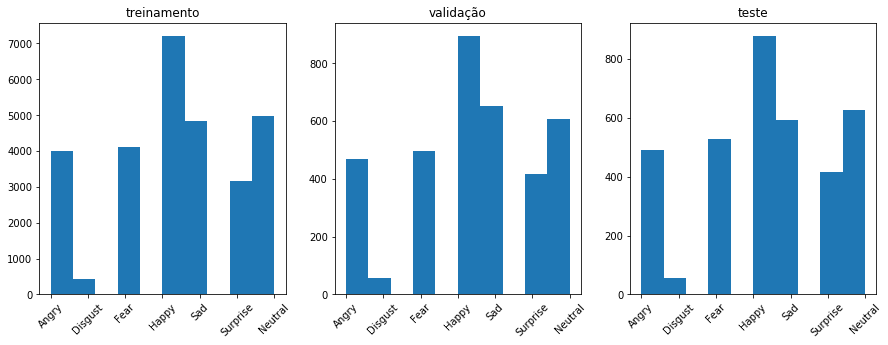

In [10]:
# histograma das bases de treinamento, validação e teste
def setup_axe(axe,df,title):
    axe.hist(df['emotion'])
    axe.set_xticks(list(range(len(labels))))
    axe.set_xticklabels(labels, rotation=45)
    axe.set_title(title)

fig, axes = plt.subplots(1,3, figsize=(15,5))
setup_axe(axes[0],df_train,'treinamento')
setup_axe(axes[1],df_valid,'validação')
setup_axe(axes[2],df_test,'teste')
plt.show()

In [11]:
# (train) pourcentage of images by emotion
ne = df_train['emotion'].value_counts(ascending=True)
for k,v in zip(ne.keys(),ne.values):
    pct = round(v/n*100,2)
    print(f'({pct}%) {v} {labels[k]}')

(1.21%) 436 Disgust
(8.84%) 3171 Surprise
(11.13%) 3995 Angry
(11.42%) 4097 Fear
(13.46%) 4830 Sad
(13.84%) 4965 Neutral
(20.1%) 7215 Happy


In [12]:
# buscar imagem + emoção a partir de uma linha da base de dados
# as imagens estão em formato de numpy array com os valores RGB de cada pixel: ex (48,48,3)
def row2image(row):
    pixels, emotion = row['pixels'], row['emotion']
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

# apresenta imagem com o título (label da expressão/emoção)
# as imagens estão em formato de numpy array com os valores RGB de cada pixel: ex (48,48,3)
def show(img_title):
    plt.imshow(img_title[0])
    plt.title(labels[img_title[1]])

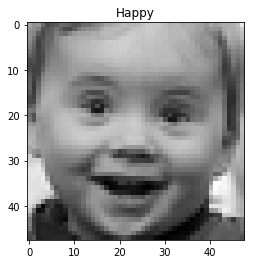

In [13]:
# Não somos Gilberto Gil, mas vamos de 2222
row = df_train.iloc[2222]
img = row2image(row)
show(img)

# Armazenar os dados (pixels) em forma de imagens nas pastas train/val/test

In [14]:
# cria as pastas train, val e test
Path(PATH/'train').mkdir(exist_ok=True)
Path(PATH/'valid').mkdir(exist_ok=True)
Path(PATH/'test').mkdir(exist_ok=True)

In [15]:
PATH_train = PATH/'train'
PATH_valid = PATH/'valid'
PATH_test = PATH/'test'

In [16]:
# cria as 7 pastas das emoções em cada uma das pastas train, train, val e test
for l in labels:
    Path(PATH_train/l).mkdir(exist_ok=True)
    Path(PATH_valid/l).mkdir(exist_ok=True)
    Path(PATH_test/l).mkdir(exist_ok=True)

In [24]:
# create images from pixels and save them into their corresponding subfolder of train, val and test
def createImages(df,path):
    for e in range(len(labels)):
        df_e = df[df['emotion'] == e]
        path_e = path/labels[e]
        i=0
        for index, row in df_e.iterrows():
            img = row2image(row)
            image = PIL.Image.fromarray(img[0], 'RGB')
            fname = str(e)+'_'+str(i)+'.jpg'
            image.save(path_e/fname)
            i += 1

In [23]:
%%time
createImages(df_train,PATH_train)
createImages(df_valid,PATH_valid)
createImages(df_test,PATH_test)

CPU times: user 1min 56s, sys: 1.56 s, total: 1min 58s
Wall time: 1min 58s


In [17]:
p = PATH_train/'Angry'
p.ls()[:5]

[PosixPath('FER/fer2013/train/Angry/0_3571.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_2571.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_628.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_1527.jpg'),
 PosixPath('FER/fer2013/train/Angry/0_1206.jpg')]

# Get Dataset and Dataloader (ImageDataBunch in fastai v1)

In [18]:
# data augmentation
tfms = get_transforms()

In [32]:
# ImageDataBunch
# bs=16, size=299 : ajusted hyper-parameters to resnet50
data = ImageDataBunch.from_folder(PATH, ds_tfms=tfms, bs=16, size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None

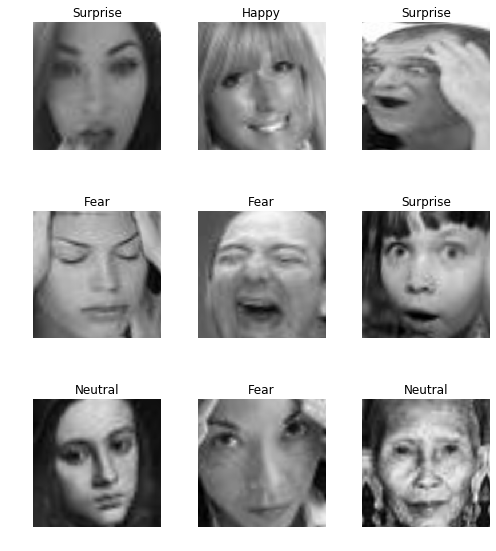

In [33]:
data.show_batch(rows=3, figsize=(7,8))

In [34]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'],
 7,
 28709,
 3589)

# Train model (resnet50)

In [36]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy]).to_fp16()

In [37]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.511601,1.402835,0.463918,03:57
1,1.325418,1.187967,0.551964,03:55
2,1.224031,1.116950,0.571190,03:55
3,1.187370,1.104678,0.579827,03:55


In [38]:
learn.save('fer2013-stage-1')

In [39]:
learn.load('fer2013-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


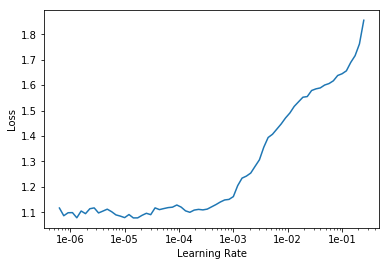

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.105682,1.051620,0.606854,05:49
1,1.034057,1.019701,0.616049,05:50


In [44]:
learn.save('fer2013-stage-2')

In [45]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.054737,1.004100,0.619950,05:50
1,1.002606,0.986314,0.633045,05:50


In [46]:
learn.save('fer2013-stage-3')

In [47]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.981047,0.971660,0.636110,05:50
1,0.917073,0.962197,0.643076,05:50


In [48]:
learn.save('fer2013-stage-4')

In [49]:
learn.load('fer2013-stage-4')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [50]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.912311,0.957860,0.636946,05:50
1,0.831618,0.947886,0.650042,05:50


In [51]:
learn.save('fer2013-stage-5')

# Results

In [52]:
learn.load('fer2013-stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [53]:
interp = ClassificationInterpretation.from_learner(learn)

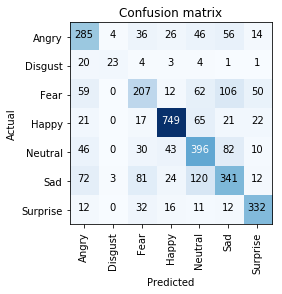

In [56]:
interp.plot_confusion_matrix()

RuntimeError: expected scalar type Half but found Float

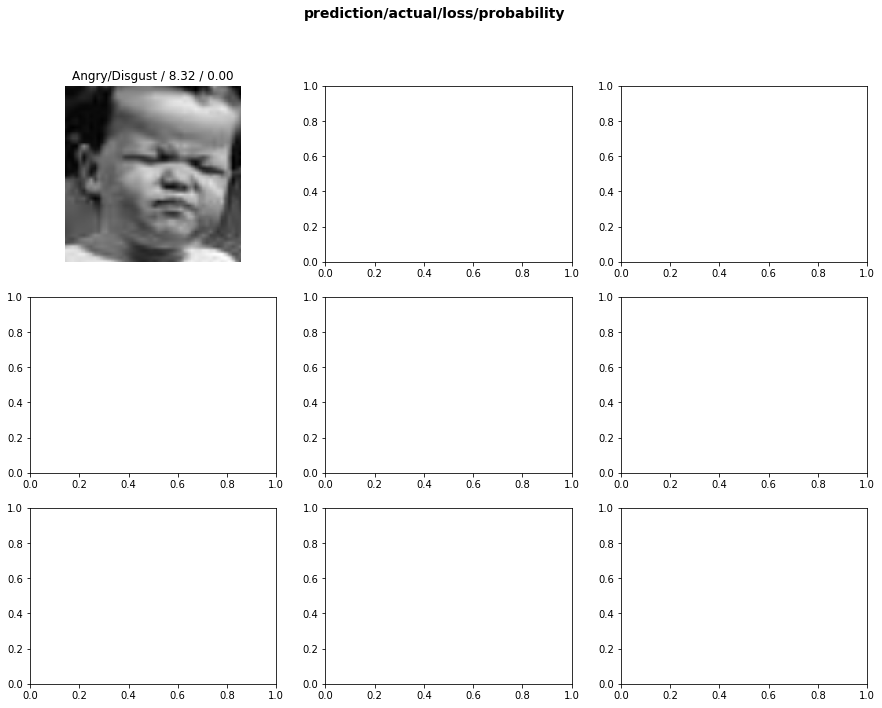

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

# Acurácia

In [58]:
learn.load('fer2013-stage-5')

Learner(data=ImageDataBunch;

Train: LabelList (28709 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Valid: LabelList (3589 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Surprise,Surprise,Surprise,Surprise,Surprise
Path: FER/fer2013;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [59]:
val_probs, val_targets = learn.get_preds()

In [60]:
val_preds = torch.argmax(val_probs,1)

In [61]:
val_acc = (val_preds == val_targets).type(torch.FloatTensor).mean().item()
print(f'valid accuracy: {round(val_acc*100,2)}%')

valid accuracy: 65.0%


# Utilizando o modelo em produção (predição de novas fotos)

In [62]:
data.classes

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

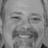

In [63]:
# get image from test folder (images arquived in subfolders)
p = PATH_test/'Happy'
url = p.ls()[1]
img = open_image(url)
img

In [64]:
# get prediction
#probs = learn.predict(img)
#prediction = learn.data.classes[probs.argmax()]
#prediction

pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Happy

In [79]:
%pwd

'/home/leonsolon/.fastai/data'

--2019-03-27 21:07:56--  http://thesharpe.com/wp-content/uploads/2017/01/surprise-someone-1-1024x768.jpg
Resolving thesharpe.com (thesharpe.com)... 78.153.213.8, 2a01:a8:dc0:331::1a7
Connecting to thesharpe.com (thesharpe.com)|78.153.213.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96123 (94K) [image/jpeg]
Saving to: ‘surprise-someone-1-1024x768.jpg’

surprise-someone-1- 100%[===================>]  93.87K   223KB/s    in 0.4s    

2019-03-27 21:07:57 (223 KB/s) - ‘surprise-someone-1-1024x768.jpg’ saved [96123/96123]



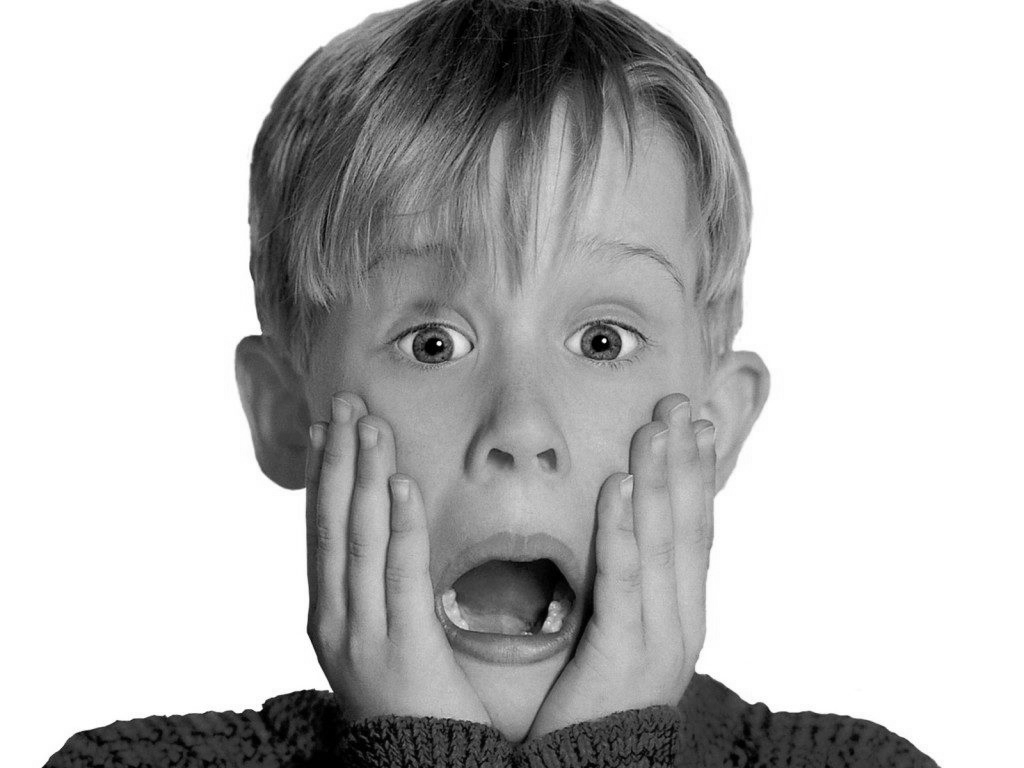

In [83]:
import requests
from io import BytesIO

!wget http://thesharpe.com/wp-content/uploads/2017/01/surprise-someone-1-1024x768.jpg
img = PIL.Image.open('surprise-someone-1-1024x768.jpg').convert('LA')
img.save('surprise-someone-1-1024x768.png')    
    
    
img = open_image('./surprise-someone-1-1024x768.png')
img

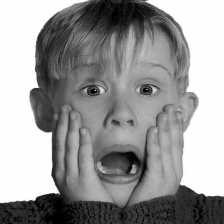

In [84]:
tfms = get_transforms()

for transformation in tfms:
    img = img.apply_tfms(transformation, size=224)

img

In [85]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Fear